<a href="https://colab.research.google.com/github/Binhcore/I2D/blob/main/%5BFull_Code%5D_Lecture_7_Vision_Transformer_with_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.10.0+cu111


### Import CIFAR data

In [ ]:
data_path = './cifar10'
batch_size = 1024
train_dataset = torchvision.datasets.CIFAR10(data_path, True, 
                                             transform= torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(data_path, False, 
                                            transform= torchvision.transforms.ToTensor(), download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Define the Device

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Get sample

In [ ]:
sample = next(iter(train_dataloader))
# sample = test_dataset[1]
print(sample[0].shape)
print(sample[1])

torch.Size([1024, 3, 32, 32])
tensor([6, 6, 4,  ..., 8, 4, 7])


### Try to plot the images

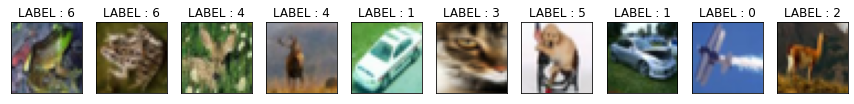

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for plot_idx in range(10):
    ax[plot_idx].imshow(sample[0][plot_idx].permute(1, 2, 0))
    ax[plot_idx].set_title('LABEL : {}'.format(sample[1][plot_idx]))
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])
plt.show()

In [ ]:
p = torch.ones(4, 5, 6)
print(p.shape)
p = p.permute(2, 1, 0)
print(p.shape)

torch.Size([4, 5, 6])
torch.Size([6, 5, 4])


### Try to divide the image into patches

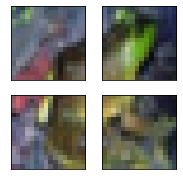

In [ ]:
patches = sample[0].unfold(2, 16, 16).unfold(3, 16, 16).reshape(batch_size, 3, -1, 16, 16).permute(0, 2, 1, 3, 4)
# patches = sample[0].unfold(2, 16, 16).unfold(3, 16, 16).reshape(batch_size, -1, 3, 16, 16) <- does not work!
fig, ax = plt.subplots(2, 2, figsize=(3, 3))
for i in range(2):
    for j in range(2):
        ax[i][j].imshow(patches[0][i*2+j].permute(1, 2, 0))
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

### Define the simple ViT model

In [ ]:
class SimpleViT(nn.Module):
    def __init__(self, feat_dim, img_size, patch_size, dim_output, nhead, num_layers):
        super(SimpleViT, self).__init__()
        
        ## define the attribute
        self.feat_dim = feat_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.dim_output = dim_output
        self.nhead = nhead
        self.num_layers = num_layers
        
        ### define layers
        # 3 X p_s x p_s -> flatten -> 3*patch_size**2
        self.inp_linear_layer = nn.Linear(3*patch_size**2, feat_dim)
        
        # complicated shape! 
        self.pos_embedding = nn.Parameter(torch.randn(img_size//(patch_size**2)+1, 1, feat_dim))

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feat_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # complicated shape!
        self.init_param = nn.Parameter(torch.randn(1, 1, feat_dim))

        # output linear layer
        self.out_linear_layer = nn.Linear(feat_dim, dim_output)
        
    def forward(self, img):
        ## get image shape
        B, D, H, W = img.shape

        # divide image into patches
        patches = img.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).reshape(B, D, -1, self.patch_size, self.patch_size).permute(0, 2, 1, 3, 4)
        
        # run the VIT
        B, N, D, H, W = patches.shape

        # flatten the patch into vectors.
        inp = patches.reshape(B, N, D*H*W).permute(1, 0, 2) # N, B, D' (T, B, D)

        # PUT linear layer to the inp
        inp = self.inp_linear_layer(inp) # N B feat_dim

        # add the learnable initial embedding. -> we need to add 1 by B by feat_dim to N by B by feat_dim => (N+1) by B by feat_dim
        inp = torch.cat([self.init_param.repeat(1, B, 1), inp], dim=0) # (N+1) by B by feat_dim

        # add the positional embedding (N+1 by 1 by feat_dim)
        inp += self.pos_embedding     

        # put input to transformer encoder   
        out = self.transformer_encoder(inp)
        
        # get output from the the first layer 
        out = self.out_linear_layer(out[0])
        
        return out

### Define the model and optimizer

In [ ]:
model = SimpleViT(feat_dim=1024, img_size=32, patch_size=8, dim_output=10, nhead=8, num_layers=6)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Define the function for training

In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    img = sample[0].float().to(device)
    label = sample[1].long().to(device) 
    
    pred = model(img)

    num_correct = sum(torch.argmax(pred, dim=1) == label)
    
    pred_loss = criterion(pred, label)
    
    # Try to add the regularization loss!

    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

### Define function for testing

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        img = sample[0].float().to(device)
        label = sample[1].long().to(device) 

        pred = model(img)
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Run training and testing for 200 epochs

In [ ]:
max_epoch = 200
tmp_path = './checkpoint.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, tmp_path)
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)

    print('[EPOCH {}] tr_loss : {}, te_loss : {} , te_accu = {}'.format(epoch+1, train_loss, test_loss, test_accu))

  0%|          | 0/200 [00:00<?, ?it/s]

[EPOCH 1] tr_loss : 2.408102278806726, te_loss : 2.2889762878417965 , te_accu = 0.13679999999999998
[EPOCH 2] tr_loss : 2.196884914320342, te_loss : 2.0713794946670534 , te_accu = 0.213
[EPOCH 3] tr_loss : 2.068079111527423, te_loss : 2.025296211242676 , te_accu = 0.22390000000000004
[EPOCH 4] tr_loss : 2.0054106225772776, te_loss : 1.9231728792190552 , te_accu = 0.29040000000000005
[EPOCH 5] tr_loss : 1.921308979696157, te_loss : 1.854086351394653 , te_accu = 0.31770000000000004
[EPOCH 6] tr_loss : 1.8495533223054852, te_loss : 1.8068124294281007 , te_accu = 0.3291
[EPOCH 7] tr_loss : 1.8061631820639779, te_loss : 1.7079037547111509 , te_accu = 0.3701
[EPOCH 8] tr_loss : 1.7348386170912764, te_loss : 1.688767981529236 , te_accu = 0.38149999999999995
[EPOCH 9] tr_loss : 1.6792490360688188, te_loss : 1.690370786190033 , te_accu = 0.38730000000000003
[EPOCH 10] tr_loss : 1.6361629306053622, te_loss : 1.5898499727249145 , te_accu = 0.4254
[EPOCH 11] tr_loss : 1.5996675783274132, te_loss :